In [446]:
# This notebook runs all of the simulations that were used to generate
# plots for the aLIGO interferometric sensing and control talk at the UF group meeting
# 10/27/2015

# In this notebook we'll use the kat file "FPcavISC.kat" to look at PDH sensing 
# for a FP cavity, and wavefront sensing using the Ward technique.

# Import stuff and read in base kat file
import pykat
import pylab as pl
%matplotlib inline
import pandas
from pandas import DataFrame 

katfilename = "FPcavISC.kat"

basekat = pykat.finesse.kat()
basekat.loadKatFile(katfilename)
basekat.verbose = False

# define some constants that we'll use throughout the notebook
maxtem = 5
MHz=1e-6
urad=1e6
mW=1e3

Saving data 100%


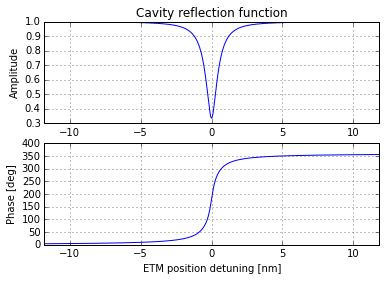

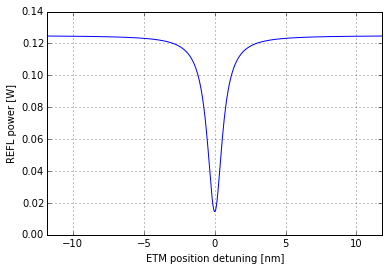

In [453]:
# First let's plot the reflection function of the cavity in amplitude and phase

kat = basekat.deepcopy()

# This requires us to add a couple of amplitude detectors, one looking at the 
# cavity input field, and one looking at the cavity reflected field.

kat.parseCommands("""
        ad adREFL 0 nITMin
        ad adIN 0 nITMin*
        """)

# Let's also add a power photodetector so we can plot the reflection drop 
# in power around resonance

kat.parseCommands("""
        pd pdREFL nPDHandWFSA
        """)

# We'll make our x axis variable tuning the microscopic position of the ETM
# From about -5 to 5 degrees (360 degrees = 1 wavelength) in 1000 steps

kat.parseCommands("""
        xaxis ETM phi lin -4 4 1000
        """)

# Make sure that the data is saved as complex numbers, from which we can extract
# amplitude and phase

kat.parseCommands("yaxis abs:deg")

# Run the simulation and save the outputs in "outs"

out=kat.run(printerr=1)

# reflection function amplitude is reflection divided by input
refl_amp = abs(out["adREFL"])/abs(out["adIN"])
# reflection function phase is difference between reflection and input
refl_phase = pl.angle(out["adREFL"])-pl.angle(out["adIN"])
# unwrap phase to avoid jumps of 2pi
refl_phase = pl.unwrap(refl_phase)*180/pl.pi

# convert tuning axis to nm
ETMpos = out.x/360*1064e-9*1e9

# plot the results
pl.figure()
pl.subplot(211)
pl.plot(ETMpos,refl_amp)
pl.title("Cavity reflection function")
pl.ylabel("Amplitude")
pl.grid()
pl.xlim((ETMpos.min(), ETMpos.max()))
pl.subplot(212)
pl.plot(ETMpos,refl_phase,label="REFL phase")
pl.ylabel("Phase [deg]")
pl.xlabel("ETM position detuning [nm]")
pl.xlim((ETMpos.min(), ETMpos.max()))
pl.grid()
pl.savefig("plots/cavREFLamp_ETMpos.pdf")

pl.figure()
pl.plot(ETMpos,out["pdREFL"])
pl.ylabel("REFL power [W]")
pl.xlabel("ETM position detuning [nm]")
pl.xlim((ETMpos.min(), ETMpos.max()))
pl.grid()
pl.savefig("plots/cavREFLpow_ETMpos.pdf")

Saving data 100%


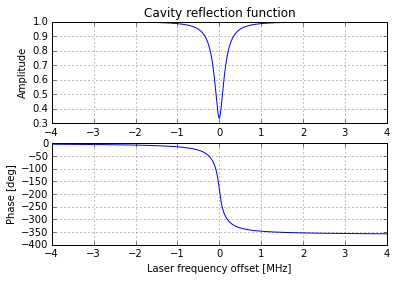

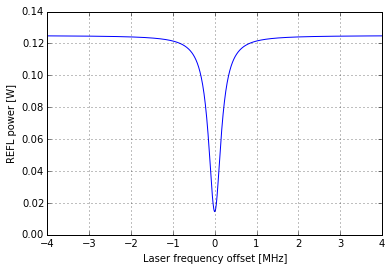

In [454]:
# Now let's repeat that, but this time we keep the cavity 
# tuning fixed and tune the laser frequency instead, to 
# Show that the two are equivalent...

kat = basekat.deepcopy()

kat.parseCommands("""
        ad adREFL 0 nITMin
        ad adIN 0 nITMin*
        pd pdREFL nPDHandWFSA
        yaxis abs:deg
        """)

kat.parseCommands("""
        xaxis laser f lin -4M 4M 1000
        put adREFL f $x1
        put adIN f $x1"""
        )

out=kat.run(printerr=1)

# reflection function amplitude is reflection divided by input
refl_amp = abs(out["adREFL"])/abs(out["adIN"])
# reflection function phase is difference between reflection and input
refl_phase = pl.angle(out["adREFL"])-pl.angle(out["adIN"])
# unwrap phase to avoid jumps of 2pi
refl_phase = pl.unwrap(refl_phase)*180/pl.pi

# plot the results
pl.figure()
pl.subplot(211)
pl.plot(out.x*MHz,refl_amp)
pl.title("Cavity reflection function")
pl.ylabel("Amplitude")
pl.grid()
pl.subplot(212)
pl.plot(out.x*MHz,refl_phase,label="REFL phase")
pl.ylabel("Phase [deg]")
pl.xlabel("Laser frequency offset [MHz]")
pl.grid()
pl.savefig("plots/cavREFLamp_laserf.pdf")

pl.figure()
pl.plot(out.x*MHz,out["pdREFL"])
pl.ylabel("REFL power [W]")
pl.xlabel("Laser frequency offset [MHz]")
pl.grid()
pl.savefig("plots/cavREFLpow_laserf.pdf")

Saving data 100%


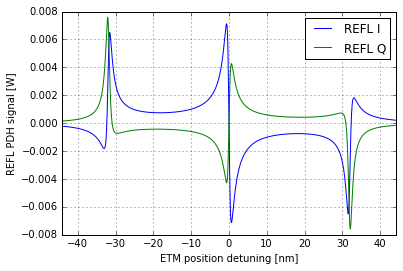

In [479]:
# Now we want to add a photodiode in reflection of the cavity that
# is demodulated at the phase modulation frequency. This is what we'll 
# Use to generate the PDH length sensing error signal

kat=basekat.deepcopy()

# Add two detectors, demodulated at the modulation frequency, with 90deg 
# different demod phases (but not tuned specifically yet)
kat.parseCommands("""
        pd1 PDHPDI $fmod 0 nPDHandWFSA
        pd1 PDHPDQ $fmod 90 nPDHandWFSA
        """)

# Use the same xaxis as before, but with a wider range
kat.parseCommands("""
        xaxis ETM phi lin -15 15 1000
        """)

out=kat.run(printerr=1)

# convert tuning axis to nm
ETMpos = out.x/360*1064e-9*1e9

pl.figure()
pl.plot(ETMpos,out["PDHPDI"],label="REFL I")
pl.plot(ETMpos,out["PDHPDQ"],label="REFL Q")
pl.legend()
pl.ylabel("REFL PDH signal [W]")
pl.xlabel("ETM position detuning [nm]")
pl.xlim((ETMpos.min(), ETMpos.max()))
pl.grid()

Saving data 100%
  ** removing line 'diff ETM phi'
Removed existing object 'xaxis' of type <class 'pykat.commands.xaxis'> to add line 'xaxis ETM phi lin -15 15 1000'
Saving data 100%


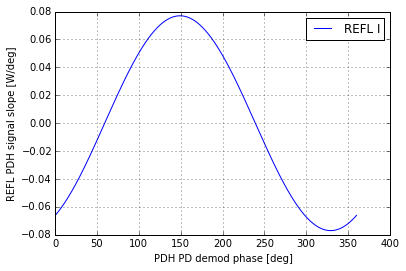

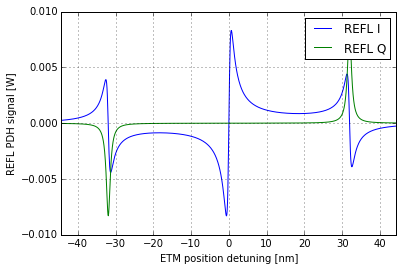

In [481]:
# REFL I looks OK, but we really want to have all the signal in I, and none in Q.
# Let's tune the demod phase to make that happen.

kat=basekat.deepcopy()

# Add PDH detectors again, demodulated at the modulation frequency, 
# with 0 and 90deg demod phases which will be overwritten anyway...
kat.parseCommands("pd1 PDHPDI $fmod 0 nPDHandWFSA")
kat.parseCommands("pd1 PDHPDQ $fmod 90 nPDHandWFSA")

# Now we want to look at the slope of the error signal, so we use the diff command

kat.parseCommands("diff ETM phi")

# Now on the xaxis we want to tune the demod phase...
kat.parseCommands("xaxis PDHPDI phase lin 0 360 3600")

out=kat.run(printerr=1)

# plot the results...

pl.figure()
pl.plot(out.x,out["PDHPDI"],label="REFL I")
pl.legend()
pl.ylabel("REFL PDH signal slope [W/deg]")
pl.xlabel("PDH PD demod phase [deg]")
pl.grid()

# and find the optimal demod phase:
slopes = out["PDHPDI"]

m = max(slopes)
for i, j in enumerate(slopes):
    if j == m:
        max_slope_el = i

opt_demod_phase = out.x[max_slope_el]

# now set that optimal demod phase for PDHPDI, and that +90deg for PDHPDQ:
kat.PDHPDI.phi1 = opt_demod_phase 
kat.PDHPDQ.phi1 = opt_demod_phase + 90

# and rerun the previous simulation, expect with nicely tuned demod phases.

# first get rid of the diff command

kat.removeLine("diff")

# Use the same xaxis as before but with a wider range
kat.parseCommands("""
        xaxis ETM phi lin -15 15 1000
        """)

out=kat.run(printerr=1)

# convert tuning axis to nm
ETMpos = out.x/360*1064e-9*1e9

pl.figure()
pl.plot(ETMpos,out["PDHPDI"],label="REFL I")
pl.plot(ETMpos,out["PDHPDQ"],label="REFL Q")
pl.legend()
pl.ylabel("REFL PDH signal [W]")
pl.xlabel("ETM position detuning [nm]")
pl.xlim((ETMpos.min(), ETMpos.max()))
pl.grid()
# this time we'll save the plot:
pl.savefig("plots/cavPDHsigs_ETMpos.pdf")

Saving data 100%


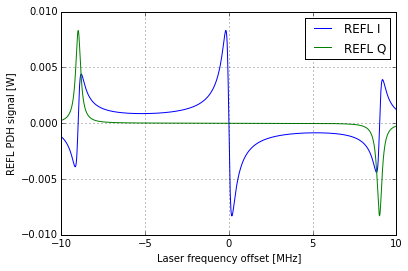

In [485]:
# Again, we'll do this for a laser frequency detuning instead 
# just to show that it's equivalent...

kat=basekat.deepcopy()

kat.parseCommands("pd1 PDHPDI $fmod 0 nPDHandWFSA")
kat.parseCommands("pd1 PDHPDQ $fmod 90 nPDHandWFSA")

# now set that optimal demod phase for PDHPDI, and that +90deg for PDHPDQ:
kat.PDHPDI.phi1 = opt_demod_phase 
kat.PDHPDQ.phi1 = opt_demod_phase + 90

kat.parseCommands("xaxis laser f lin -10M 10M 1000")

out=kat.run(printerr=1)

pl.figure()
pl.plot(out.x*MHz,out["PDHPDI"],label="REFL I")
pl.plot(out.x*MHz,out["PDHPDQ"],label="REFL Q")
pl.legend()
pl.ylabel("REFL PDH signal [W]")
pl.xlabel("Laser frequency offset [MHz]")
pl.grid()
# this time we'll save the plot:
pl.savefig("plots/cavPDHsigs_laserf.pdf")

Saving data 100%


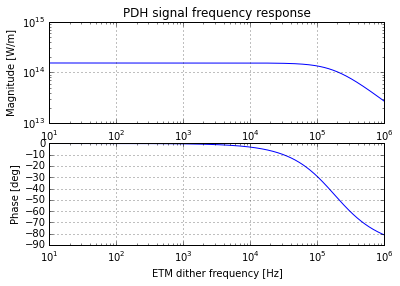

In [459]:
# Now let's take a look at the frequency dependence
# of the PDH sensing gain for ETM position dither.

kat = basekat.deepcopy()

# First let's add a dither signal to the ETM position:
kat.parseCommands("fsig dither ETM z 1 0")

# Now let's sweep the frequency of the dither on the xaxis:
kat.parseCommands("xaxis dither f log 10 1M 1000")

# We have to add a PDH detector, but this time it needs to be 
# demodulated _twice_: once at the RF modulation frequency and 
# again at the dither signal frequency:

kat.parseCommands("pd2 PDHPDIsig $fmod -10 1 nPDHandWFSA")

# We should set the demodulation phase for the RF to be the same 
# as the optimal demod phase we calculated earlier:

kat.PDHPDIsig.phi1 = kat.PDHPDIsig.phi1 = opt_demod_phase 

# Now we have to sweep the second demod frequency along with 
# the dither signal frequency:

kat.parseCommands("put PDHPDIsig f2 $x1")

# If we give no demod phase for the second demodulation stage, Finesse 
# will output real and imaginary parts and we can look at amplitude and 
# phase of the signal like so:
kat.parseCommands("yaxis abs:deg")

# Scale the results to units of meters
kat.parseCommands("scale meter""")

out = kat.run(printerr=1)

pl.figure()
pl.subplot(211)
pl.loglog(out.x,abs(out["PDHPDIsig"]))
pl.grid()
pl.xlabel("ETM dither frequency [Hz]")
pl.ylabel("Magnitude [W/m]")
pl.title("PDH signal frequency response")
pl.subplot(212)
pl.semilogx(out.x,pl.angle(out["PDHPDIsig"])*180/pl.pi)
pl.grid()
pl.xlabel("ETM dither frequency [Hz]")
pl.ylabel("Phase [deg]")
pl.savefig("plots/PDH_freq_dependence.pdf")


Saving data 100%


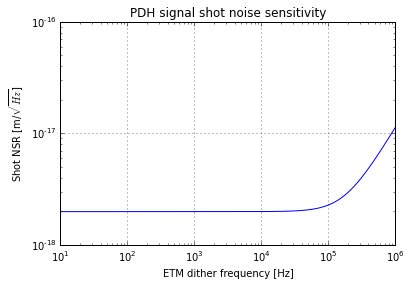

In [464]:
# Now we can look at the shot noise sensitivity of the PDH sensing:

kat = basekat.deepcopy()

kat.parseCommands("""
        qnoisedS PDHNSR 2 9000000 -10 1 max nPDHandWFSA
        fsig dither ETM z 1 0
        xaxis dither f log 10 1M 1000
        put PDHNSR f2 $x1
        """)

kat.PDHNSR.phi1 = opt_demod_phase 

out=kat.run(printerr=1)

pl.figure()
pl.loglog(out.x,abs(out["PDHNSR"]))
pl.grid()
pl.xlabel("ETM dither frequency [Hz]")
pl.ylabel("Shot NSR [m/$\sqrt{Hz}$]")
pl.title("PDH signal shot noise sensitivity")
pl.savefig("plots/PDH_NSR.pdf")

Saving data 100%
Saving data 100%


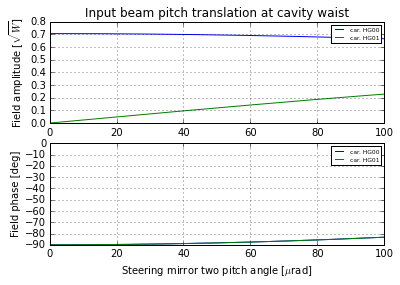

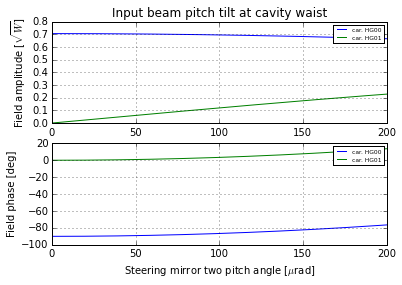

In [465]:
# Now it's time to start looking at some alignment signals
# Let's start off with looking at pitch misalignment of the 
# input beam with respect to the cavity eigenmode.
#
# Since we have two steering mirrors, at distances of 1m and 
# 2m from the cavity input mirror respectively, we know that 
# moving steering mirror 2 in the opposite direction as steering 
# mirror 1 but by twice as much will cause a pure tilt of the beam 
# at the cavity waist location.
#
# Alternatively, we know that moving the mirrors by equal amounts but 
# in opposite directions should cause a pure translation of the beam 
# at the cavity waist location.
#
# We can check this by looking at the relative phases of the HG00 modes and the 
# HG10 modes at the cavity waist location. If it's a pure tilt, they will be 
# 90deg out of phase, and if it's a pure translation, they will be in phase.

kat = basekat.deepcopy()

# add a bunch of amplitude detectors to detect specific modes and frequency 
# components at the cavity input:

kat.parseCommands("""
        ad carHG00_cavin 0 0 0 nITMin*
        ad carHG01_cavin 0 1 0 nITMin*
        """)

# Doing pure translation first...

kat.parseCommands("""
        xaxis Steer2 ybeta lin 0 100u 400
        put Steer1 ybeta $mx1
        yaxis lin abs:deg
        """)

# Make sure we are using higher-order modes in the calculation
kat.maxtem = maxtem

out=kat.run(printerr=1)

pl.figure()
pl.subplot(211)
pl.plot(out.x*urad,abs(out["carHG00_cavin"]),label='car. HG00')
pl.plot(out.x*urad,abs(out["carHG01_cavin"]),label='car. HG01')
pl.ylabel('Field amplitude [$\sqrt{W}$]')
pl.title('Input beam pitch translation at cavity waist')
pl.legend(prop={'size':6})
pl.grid()
pl.subplot(212)
pl.plot(out.x*urad,pl.angle(out["carHG00_cavin"])*180/pl.pi,label='car. HG00')
pl.plot(out.x*urad,pl.angle(out["carHG01_cavin"])*180/pl.pi,label='car. HG01')
pl.xlabel('Steering mirror two pitch angle [$\mu$rad]')
pl.ylabel('Field phase [deg]')
pl.legend(prop={'size':6})
pl.grid()
pl.savefig("plots/waist_pitch_trans_amps.pdf")

# Indeed we see that the HG00 and HG10 modes are in phase, so we have translation.

# Now doing pure tilt...

kat = basekat.deepcopy()

kat.parseCommands("""
        ad carHG00_cavin 0 0 0 nITMin*
        ad carHG01_cavin 0 1 0 nITMin*
        """)

kat.parseCommands("""
        xaxis Steer2 ybeta lin 0 200u 400
        func waisttilt = (-1)*0.5*$x1
        put Steer1 ybeta $waisttilt
        yaxis lin abs:deg
        """)

# Make sure we are using higher-order modes in the calculation
kat.maxtem = maxtem

out=kat.run(printerr=1)

pl.figure()
pl.subplot(211)
pl.plot(out.x*urad,abs(out["carHG00_cavin"]),label='car. HG00')
pl.plot(out.x*urad,abs(out["carHG01_cavin"]),label='car. HG01')
pl.legend(prop={'size':6})
pl.ylabel('Field amplitude [$\sqrt{W}$]')
pl.title('Input beam pitch tilt at cavity waist')
pl.grid()
pl.subplot(212)
pl.plot(out.x*urad,pl.angle(out["carHG00_cavin"])*180/pl.pi,label='car. HG00')
pl.plot(out.x*urad,pl.angle(out["carHG01_cavin"])*180/pl.pi,label='car. HG01')
pl.xlabel('Steering mirror two pitch angle [$\mu$rad]')
pl.ylabel('Field phase [deg]')
pl.legend(prop={'size':6})
pl.grid()
pl.savefig("plots/waist_pitch_tilt_amps.pdf")

# And here we see that the HG00 and HG10 modes are 90deg out of phase, so we have tilt.

Saving data 100%
Saving data 100%


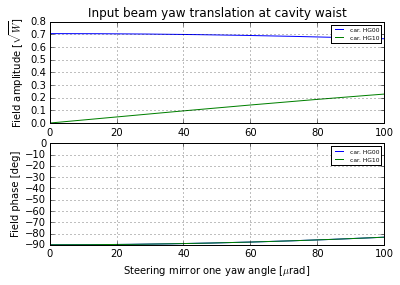

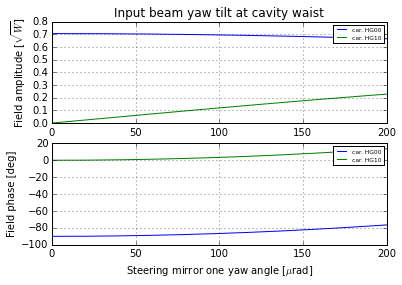

In [466]:
# Now that we know we can drive the two different pitch DOFs independently,
# Let's do the same for yaw. As before, to get pure tilt we have to move 
# steering mirror 2 by twice as much as steering mirror 1.

# We get pure translation, as before, by doing equal and opposite acutation 
# steering mirrors 1 and 2. 

kat = basekat.deepcopy()

# add a bunch of amplitude detectors to detect specific modes and frequency 
# components at the cavity input:

kat.parseCommands("""
        ad carHG00_cavin 0 0 0 nITMin*
        ad carHG10_cavin 1 0 0 nITMin*
        """)

# Doing pure translation first...

kat.parseCommands("""
        xaxis Steer2 xbeta lin 0 100u 400
        put Steer1 xbeta $x1
        yaxis lin abs:deg
        """)

# Make sure we are using higher-order modes in the calculation
kat.maxtem = maxtem

out=kat.run(printerr=1)

pl.figure()
pl.subplot(211)
pl.plot(out.x*urad,abs(out["carHG00_cavin"]),label='car. HG00')
pl.plot(out.x*urad,abs(out["carHG10_cavin"]),label='car. HG10')
pl.ylabel('Field amplitude [$\sqrt{W}$]')
pl.title('Input beam yaw translation at cavity waist')
pl.legend(prop={'size':6})
pl.grid()
pl.subplot(212)
pl.plot(out.x*urad,pl.angle(out["carHG00_cavin"])*180/pl.pi,label='car. HG00')
pl.plot(out.x*urad,pl.angle(out["carHG10_cavin"])*180/pl.pi,label='car. HG10')
pl.xlabel('Steering mirror one yaw angle [$\mu$rad]')
pl.ylabel('Field phase [deg]')
pl.legend(prop={'size':6})
pl.grid()
pl.savefig("plots/waist_yaw_trans_amps.pdf")

# We see that we indeed get pure translation, because the HG00 mode and 
# the HG10 mode are in phase with each other.

# Now let's do pure tilt:

kat = basekat.deepcopy()

kat.parseCommands("""
        ad carHG00_cavin 0 0 0 nITMin*
        ad carHG10_cavin 1 0 0 nITMin*
        """)

kat.parseCommands("""
        xaxis Steer2 xbeta lin 0 200u 400
        func waisttilt = 0.5*$x1
        put Steer1 xbeta $waisttilt
        yaxis lin abs:deg
        """)

# Make sure we are using higher-order modes in the calculation
kat.maxtem = maxtem

out=kat.run(printerr=1)

pl.figure()
pl.subplot(211)
pl.plot(out.x*urad,abs(out["carHG00_cavin"]),label='car. HG00')
pl.plot(out.x*urad,abs(out["carHG10_cavin"]),label='car. HG10')
pl.ylabel('Field amplitude [$\sqrt{W}$]')
pl.title('Input beam yaw tilt at cavity waist')
pl.legend(prop={'size':6})
pl.grid()
pl.subplot(212)
pl.plot(out.x*urad,pl.angle(out["carHG00_cavin"])*180/pl.pi,label='car. HG00')
pl.plot(out.x*urad,pl.angle(out["carHG10_cavin"])*180/pl.pi,label='car. HG10')
pl.xlabel('Steering mirror one yaw angle [$\mu$rad]')
pl.ylabel('Field phase [deg]')
pl.legend(prop={'size':6})
pl.grid()
pl.savefig("plots/waist_yaw_tilt_amps.pdf")

# The HG10 mode and HG00 mode are not 90deg out of phase, so we have pure tilt.

Saving data 100%
Optimal distance from lens to WFSB = 0.10344m


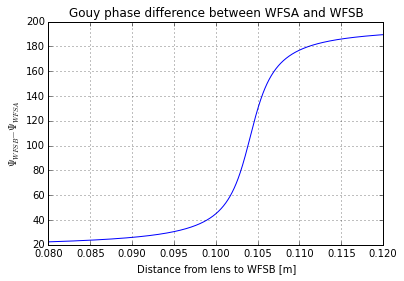

In [467]:
# Now let's start looking at wavefront sensors, and how they can 
# give us a signal for these misalignments.

# First step is to make sure that they're 90deg apart in Gouy phase.

kat = basekat.deepcopy()

# add Gouy detectors to find the accumulated Gouy phase from cavity 
# input mirror (waist location) to WFSA and WFSB.
kat.parseCommands("gouy gouy2WFSA x BS2ITM BSpickoff2REFLBS sREFLBSrefl2PDHandWFSA")
kat.parseCommands("gouy gouy2WFSB x BS2ITM BSpickoff2REFLBS sREFLBStrans2GPTlens sGPTlens2WFSB")

# sweep distance from lens to WFSB to find location which is 90deg different in Gouy 
# phase from WFSA:

kat.parseCommands("xaxis sGPTlens2WFSB L lin 0.08 0.12 1000")

out=kat.run(printerr=1)

gouydiff=out["gouy2WFSB"]-out["gouy2WFSA"]

pl.figure()
pl.plot(out.x,gouydiff)
pl.xlabel('Distance from lens to WFSB [m]')
pl.ylabel('$\Psi_{WFSB}-\Psi_{WFSA}$')
pl.grid()
pl.title('Gouy phase difference between WFSA and WFSB')
pl.savefig('plots/gouy_diff.pdf')

# find closest distance to the one that has 90deg Gouy phase difference

gouyfrom90 = abs(gouydiff-90)

m = min(gouyfrom90)
for i, j in enumerate(gouyfrom90):
    if j == m:
        gouy90_el = i

opt_lens2WFSB_L = out.x[gouy90_el]
print("Optimal distance from lens to WFSB = %gm") % opt_lens2WFSB_L



In [468]:
# Now that they're 90deg apart in Gouy phase, let's add the 
# wavefront sensors and see what we get from misaligning the cavity 
# in the 4 degrees of freedom

kat=basekat.deepcopy()

# set the length to the optimal one
kat.sGPTlens2WFSB.L = opt_lens2WFSB_L

# Now we should really phase the WFS detectors correctly. 
# WFSA should have the same demod phase as the PDH pd, since it's in the same location,
# but we need to check for WFSB. The easiest way to do this is to just add another PDH
# PD and the WFSB location, and optimize demod phase as before.

kat.parseCommands("pd1 PDHPDWFSBloc $fmod 0 nWFSB")
kat.parseCommands("diff ETM phi")
kat.parseCommands("xaxis PDHPDWFSBloc phase lin 0 360 3600")

# run the simulation

out=kat.run(printerr=1)

# and find the optimal demod phase:
slopes = out["PDHPDWFSBloc"]

m = max(slopes)
for i, j in enumerate(slopes):
    if j == m:
        max_slope_el = i

opt_demod_phase_WFSB = out.x[max_slope_el]

Saving data 100%


Saving data 100%
Saving data 100%
Saving data 100%
Saving data 100%


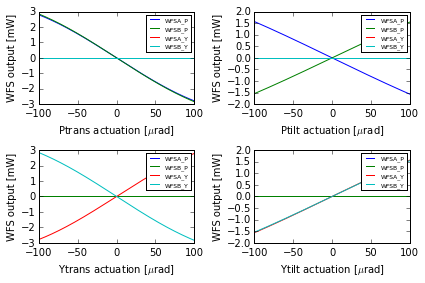

In [469]:
# Now we're ready to look at what signals we get out of the WFSs.

# Make a new kind of basekat with things already added that we aren't changing.
WFSkat = basekat.deepcopy()

# Make sure we have higher-order modes in the calculation:
WFSkat.maxtem = maxtem

# set the WFSB length to the optimal one
WFSkat.sGPTlens2WFSB.L = opt_lens2WFSB_L

# Now we can add some wavefront sensors. We'll need 4:
# One for pitch and yaw, at both locations.

WFSkat.parseCommands("""
        pd1 WFSA_P $fmod 0 nPDHandWFSA
        pdtype WFSA_P y-split
        pd1 WFSA_Y $fmod 0 nPDHandWFSA
        pdtype WFSA_Y x-split
        pd1 WFSB_P $fmod 0 nWFSB
        pdtype WFSB_P y-split
        pd1 WFSB_Y $fmod 0 nWFSB
        pdtype WFSB_Y x-split
""")

# set the demod phases of WFSA and WFSB to be optimal
WFSkat.WFSA_P.phi1 = WFSkat.WFSA_Y.phi1 = opt_demod_phase
WFSkat.WFSB_P.phi1 = WFSkat.WFSB_Y.phi1 = opt_demod_phase_WFSB

# Then let's set up a list of DOFs, and put the commands for each one in there.

DOFs = ["Ptrans","Ptilt","Ytrans","Ytilt"]

DOF_commands = {}
DOF_commands["Ptrans"] = """
xaxis Steer2 ybeta lin -100u 100u 400
put Steer1 ybeta $mx1"""

DOF_commands["Ptilt"] = """
xaxis Steer2 ybeta lin -100u 100u 400
func waisttilt = (-1)*0.5*$x1
put Steer1 ybeta $waisttilt"""

DOF_commands["Ytrans"] = """
xaxis Steer2 xbeta lin -100u 100u 400
put Steer1 xbeta $x1
"""
DOF_commands["Ytilt"] = """
xaxis Steer2 xbeta lin -100u 100u 400
func waisttilt = 0.5*$x1
put Steer1 xbeta $waisttilt
"""

# Now let's set up a list of WFSs
WFSs = ["WFSA_P","WFSB_P","WFSA_Y","WFSB_Y"]

# We should make a 4x4 matrix into which we can drop the sensing elements we're
# about to calculate.

sens_mat = pl.zeros((4,4))

# Now let's loop over the 4 DOFs and run the simulation for each one.

pl.figure()

for k, DOF in enumerate(DOFs):
    kat = WFSkat.deepcopy()
    kat.parseCommands(DOF_commands[DOF])
    out = kat.run(printerr=1)
    pl.subplot(2,2,k+1)
    for b, WFS in enumerate(WFSs):
        WFSsig=out[WFS]
        pl.plot(out.x*urad,WFSsig*mW,label=WFS)
        slope = (WFSsig[round(len(WFSsig)/2)+1]-WFSsig[round(len(WFSsig)/2)])/(out.x[round(len(WFSsig)/2)+1]-out.x[round(len(WFSsig)/2)])
        sens_mat[k,b] = slope
    pl.legend()
    pl.legend(prop={'size':6})
    pl.xlabel(DOF+' actuation [$\mu$rad]')
    pl.ylabel('WFS output [mW]')
pl.tight_layout()
pl.savefig("plots/cavWFSoutputs.pdf")

In [470]:
# and print the sensing matrix
SensMprint = DataFrame(columns=WFSs,index=DOFs)
for k, DOF in enumerate(DOFs):
    for b, WFS in enumerate(WFSs):
        SensMprint[WFS][DOF]=sens_mat[k,b]
    
print('Alignment sensing matrix in W/rad:\n')
print(SensMprint)


# So we can see that, roughly speaking, if we add WFSA and WFSB pitch signals, 
# we get a signal that is only sensitive to pitch translation of the input beam.
# Same goes if we subtract WFSA and WFSB yaw signal.

Alignment sensing matrix in W/rad:

          WFSA_P    WFSB_P    WFSA_Y    WFSB_Y
Ptrans -32.04772  -32.4887         0         0
Ptilt  -16.18884  15.96748         0         0
Ytrans         0         0  32.04772  -32.4887
Ytilt          0         0  16.18884  15.96748


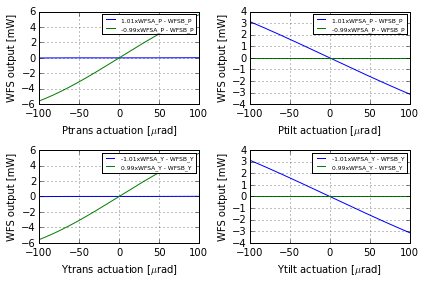

In [471]:
# We can be a bit more precise than that though, and plot the signals we get by 
# adding WFSA and WFSB signal in the ideal proportions to make a diagonalized 
# Matrix.

WFSBP2WFSAP_trans_ratio = sens_mat[0,1]/sens_mat[0,0]
WFSBP2WFSAP_tilt_ratio = sens_mat[1,1]/sens_mat[1,0]
WFSBY2WFSAY_trans_ratio = sens_mat[2,3]/sens_mat[2,2]
WFSBY2WFSAY_tilt_ratio = sens_mat[3,3]/sens_mat[3,2]

# Now plot all the combines signals for each of the 4 DOFs:

DOF="Ptrans"
kat = WFSkat.deepcopy()
kat.parseCommands(DOF_commands[DOF])

out=kat.run()

labelstr1="%1.2fxWFSA_P - WFSB_P" %WFSBP2WFSAP_trans_ratio
labelstr2="%1.2fxWFSA_P - WFSB_P" %WFSBP2WFSAP_tilt_ratio
pl.figure()
pl.subplot(221)
pl.plot(out.x*urad,mW*(out["WFSA_P"]*WFSBP2WFSAP_trans_ratio-out["WFSB_P"]),label=labelstr1)
pl.plot(out.x*urad,mW*(out["WFSA_P"]*WFSBP2WFSAP_tilt_ratio-out["WFSB_P"]),label=labelstr2)
pl.legend()
pl.legend(prop={'size':6})
pl.grid()
pl.xlabel(DOF+" actuation [$\mu$rad]")
pl.ylabel("WFS output [mW]")

DOF="Ptilt"
kat = WFSkat.deepcopy()
kat.parseCommands(DOF_commands[DOF])
out=kat.run()

labelstr1="%1.2fxWFSA_P - WFSB_P" %WFSBP2WFSAP_trans_ratio
labelstr2="%1.2fxWFSA_P - WFSB_P" %WFSBP2WFSAP_tilt_ratio
pl.subplot(222)
pl.plot(out.x*urad,mW*(out["WFSA_P"]*WFSBP2WFSAP_trans_ratio-out["WFSB_P"]),label=labelstr1)
pl.plot(out.x*urad,mW*(out["WFSA_P"]*WFSBP2WFSAP_tilt_ratio-out["WFSB_P"]),label=labelstr2)
pl.legend()
pl.legend(prop={'size':6})
pl.grid()
pl.xlabel(DOF+" actuation [$\mu$rad]")
pl.ylabel("WFS output [mW]")
                               
DOF="Ytrans"
kat = WFSkat.deepcopy()
kat.parseCommands(DOF_commands[DOF])

out=kat.run()

labelstr1="%1.2fxWFSA_Y - WFSB_Y" %WFSBY2WFSAY_trans_ratio
labelstr2="%1.2fxWFSA_Y - WFSB_Y" %WFSBY2WFSAY_tilt_ratio
pl.subplot(223)
pl.plot(out.x*urad,mW*(out["WFSA_Y"]*WFSBY2WFSAY_trans_ratio-out["WFSB_Y"]),label=labelstr1)
pl.plot(out.x*urad,mW*(out["WFSA_Y"]*WFSBY2WFSAY_tilt_ratio-out["WFSB_Y"]),label=labelstr2)
pl.legend()
pl.legend(prop={'size':6})
pl.xlabel(DOF+" actuation [$\mu$rad]")
pl.ylabel("WFS output [mW]")
pl.grid()

DOF="Ytilt"
kat = WFSkat.deepcopy()
kat.parseCommands(DOF_commands[DOF])

out=kat.run()

labelstr1="%1.2fxWFSA_Y - WFSB_Y" %WFSBY2WFSAY_trans_ratio
labelstr2="%1.2fxWFSA_Y - WFSB_Y" %WFSBY2WFSAY_tilt_ratio
pl.subplot(224)
pl.plot(out.x*urad,mW*(out["WFSA_Y"]*WFSBY2WFSAY_trans_ratio-out["WFSB_Y"]),label=labelstr1)
pl.plot(out.x*urad,mW*(out["WFSA_Y"]*WFSBY2WFSAY_tilt_ratio-out["WFSB_Y"]),label=labelstr2)
pl.legend()
pl.legend(prop={'size':6})
pl.grid()
pl.xlabel(DOF+" actuation [$\mu$rad]")
pl.ylabel("WFS output [mW]")
pl.tight_layout()
pl.savefig('plots/cavWFSoutputs_diagonalized.pdf')


In [472]:
# Now we could look at another way to generate the sensing matrix, 
# using alignment dither signals and double demodulation.

ddWFSkat = basekat.deepcopy()

ddWFSkat.maxtem = maxtem

# set the WFSB length to the optimal one
ddWFSkat.sGPTlens2WFSB.L = opt_lens2WFSB_L

# We're going to do some dither of optic alignments, so let's 
# define a dither frequency. Choosing a low frequency is a safe 
# bet here, because it avoids possible strange situations where 
# a higher-order mode signal sideband becomes resonant somewhere.

ddWFSkat.parseCommands("const f_sig 0.1")

# Add some wavefront sensors, this time demodulated twice; once at the 
# RF modulation frequency, and once at the dither signal frequency. 
# We'll need 4 again, one for pitch and yaw, at both locations.

# We could leave out the second demod phase and recover amplitude and 
# phase information (like we did for the frequency dependence of the PDH 
# signal), but for very low frequencies we can assume that zero deg demod 
# phase will be the best choice because the signal sideband wavelength is so long. 

ddWFSkat.parseCommands("""
        pd2 ddWFSA_P $fmod 0 $f_sig 0 nPDHandWFSA
        pdtype ddWFSA_P y-split
        pd2 ddWFSA_Y $fmod 0 $f_sig 0 nPDHandWFSA
        pdtype ddWFSA_Y x-split
        pd2 ddWFSB_P $fmod 0 $f_sig 0 nWFSB
        pdtype ddWFSB_P y-split
        pd2 ddWFSB_Y $fmod 0 $f_sig 0 nWFSB
        pdtype ddWFSB_Y x-split
""")

# set the RF demod phases of WFSA and WFSB to be optimal
ddWFSkat.ddWFSA_P.phi1 = ddWFSkat.ddWFSA_Y.phi1 = opt_demod_phase
ddWFSkat.ddWFSB_P.phi1 = ddWFSkat.ddWFSB_Y.phi1 = opt_demod_phase_WFSB

# Now we need to make a list of DOF commands again, but this time we're applying 
# dither signals instead of sweeping alignments. This means we don't even need an 
# xaxis! But we could make the xaxis look at different dither frequencies. Not 
# right now though.

ddWFSkat.noxaxis = True

DOF_dither_commands = {}

DOF_dither_commands["Ptrans"] = """
fsig Ptrans Steer2 ybeta $f_sig 0 1
fsig Ptrans Steer1 ybeta $f_sig 180 1"""

DOF_dither_commands["Ptilt"] = """
fsig Ptilt Steer2 ybeta $f_sig 0 1
fsig Ptilt Steer1 ybeta $f_sig 180 0.5"""

DOF_dither_commands["Ytrans"] = """
fsig Ytrans Steer2 xbeta $f_sig 0 1
fsig Ytrans Steer1 xbeta $f_sig 0 1
"""
DOF_dither_commands["Ytilt"] = """
fsig Ytilt Steer2 xbeta $f_sig 0 1
fsig Ytilt Steer1 xbeta $f_sig 0 0.5
"""

# and a list of the new double demodulatede WFSs:
ddWFSs = ["ddWFSA_P","ddWFSB_P","ddWFSA_Y","ddWFSB_Y"]

# We should make a new 4x4 matrix into which we can drop the sensing elements we're
# about to calculate.

ddsens_mat = pl.zeros((4,4))

# Now we can loop over all of them and calculate our sensing matrix.

for k, DOF in enumerate(DOFs):
    kat = ddWFSkat.deepcopy()
    kat.parseCommands(DOF_dither_commands[DOF])
    out = kat.run(printerr=1)
    for b, ddWFS in enumerate(ddWFSs):
        ddsens_mat[k,b] = out[ddWFS]

# and print the sensing matrix nicely with a DataFrame:

ddSensMprint = DataFrame(columns=ddWFSs,index=DOFs)
for k, DOF in enumerate(DOFs):
    for b, ddWFS in enumerate(ddWFSs):
        ddSensMprint[ddWFS][DOF]=ddsens_mat[k,b]
        
    
print('\nAlignment sensing matrix from double-demodulation method [W/rad]:\n')
print(ddSensMprint)

print('\nAlignment sensing matrix from slope method [W/rad]:\n')
print(SensMprint)

# and we can see that we get almost the exact same result as by sweeping the 
# misalignments on the xaxis (but much faster).

Saving data 0%
Saving data 0%
Saving data 0%
Saving data 0%

Alignment sensing matrix from double-demodulation method [W/rad]:

        ddWFSA_P  ddWFSB_P  ddWFSA_Y  ddWFSB_Y
Ptrans  32.04783  32.48882         0         0
Ptilt   16.18886 -15.96749         0         0
Ytrans         0         0  32.04783 -32.48882
Ytilt          0         0  16.18886  15.96749

Alignment sensing matrix from slope method [W/rad]:

          WFSA_P    WFSB_P    WFSA_Y    WFSB_Y
Ptrans -32.04772  -32.4887         0         0
Ptilt  -16.18884  15.96748         0         0
Ytrans         0         0  32.04772  -32.4887
Ytilt          0         0  16.18884  15.96748


Saving data 100%
Saving data 100%
Saving data 100%
Saving data 100%


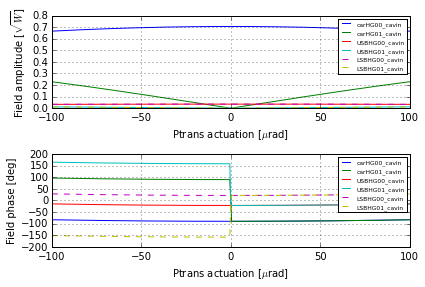

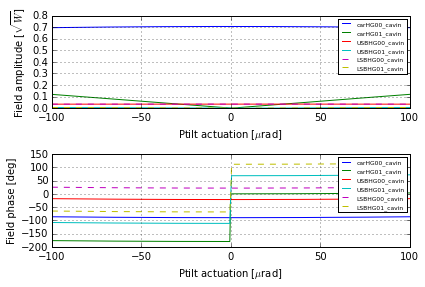

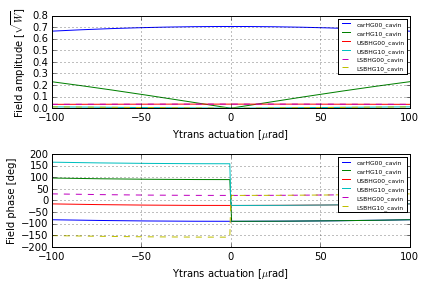

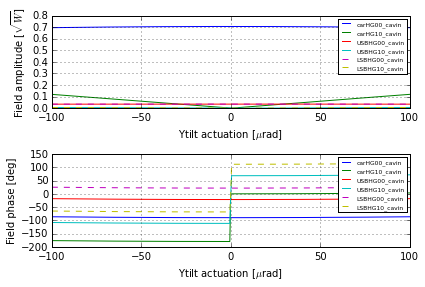

In [473]:
# We saw earlier that we had the right combination of actuation to produce just 
# tilt or just translation in both axes at the cavity waist location. 
# We could check all the fields at both WFS 
# and the cavity input.

#Pads=["USBHG00_cavin","USBHG01_cavin","LSBHG00_cavin","LSBHG01_cavin"]
#Yads=["USBHG00_cavin","USBHG10_cavin","LSBHG00_cavin","LSBHG10_cavin"]
Yads=["carHG00_cavin","carHG10_cavin","USBHG00_cavin","USBHG10_cavin","LSBHG00_cavin","LSBHG10_cavin"]
Pads=["carHG00_cavin","carHG01_cavin","USBHG00_cavin","USBHG01_cavin","LSBHG00_cavin","LSBHG01_cavin"]

for DOF in DOFs:
    kat=basekat.deepcopy()
    kat.parseCommands("yaxis abs:deg")
    kat.maxtem = maxtem
    kat.parseCommands("""
        ad carHG00_cavin 0 0 0 nITMin*
        ad USBHG00_cavin 0 0 $fmod nITMin*
        ad LSBHG00_cavin 0 0 $nfmod nITMin*
        ad carHG10_cavin 1 0 0 nITMin*
        ad USBHG10_cavin 1 0 $fmod nITMin*
        ad LSBHG10_cavin 1 0 $nfmod nITMin*
        ad carHG01_cavin 0 1 0 nITMin*
        ad USBHG01_cavin 0 1 $fmod nITMin*
        ad LSBHG01_cavin 0 1 $nfmod nITMin*
        """)
    kat.parseCommands(DOF_commands[DOF])

    out=kat.run(printerr=1)

    pl.figure()
    pl.subplot(211)
    if DOF[0]=='P':
        ads=Pads
    elif DOF[0]=='Y':
        ads=Yads
    for ad in ads:
        if ad[0]=='L':
            pl.plot(out.x*urad,abs(out[ad]),'--',label=ad)
        else:
            pl.plot(out.x*urad,abs(out[ad]),label=ad)
    pl.xlabel(DOF+" actuation [$\mu$rad]")
    pl.ylabel('Field amplitude [$\sqrt{W}$]')
    pl.legend()
    pl.legend(prop={'size':6})
    pl.grid()

    pl.subplot(212)
    for ad in ads:
        if ad[0]=='L':
            pl.plot(out.x*urad,pl.angle(out[ad])*180/pl.pi,'--',label=ad)
        else:
            pl.plot(out.x*urad,pl.angle(out[ad])*180/pl.pi,label=ad)
    
    pl.xlabel(DOF+" actuation [$\mu$rad]")
    pl.ylabel('Field phase [deg]')
    pl.legend()
    pl.legend(prop={'size':6})
    pl.grid()
    pl.tight_layout()
    pl.savefig('cavinputbeam_allfields'+DOF+'.pdf')

# Everything seems ok there... let's check at the WFS locations too

Saving data 100%
Saving data 100%
Saving data 100%
Saving data 100%
Saving data 100%
Saving data 100%
Saving data 100%
Saving data 100%


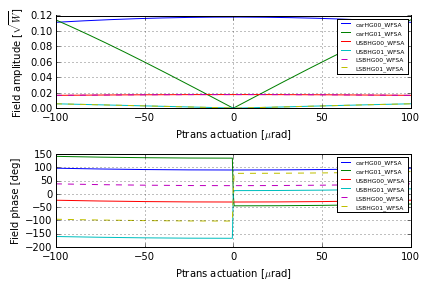

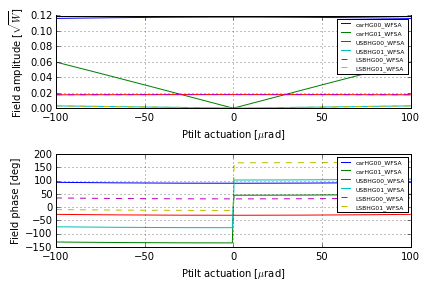

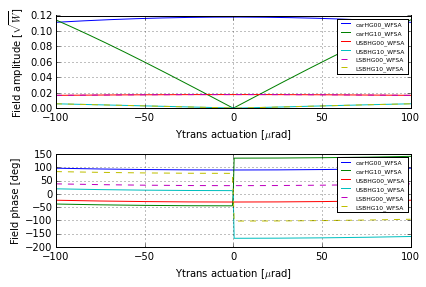

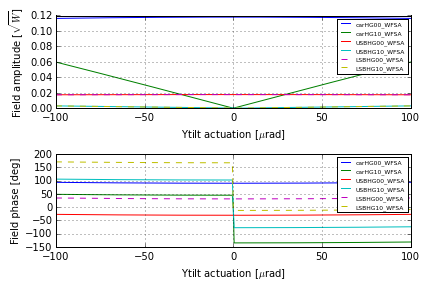

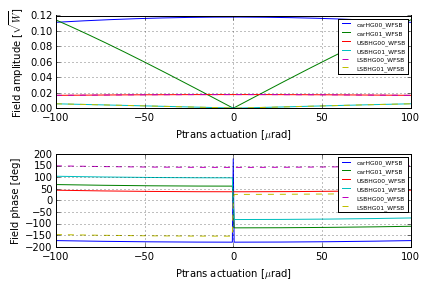

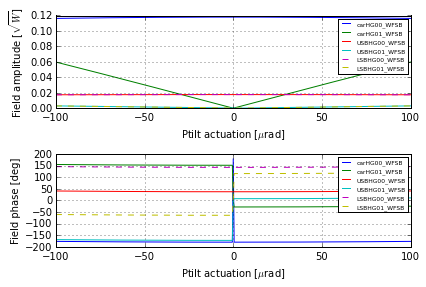

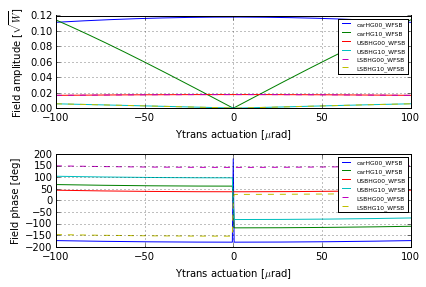

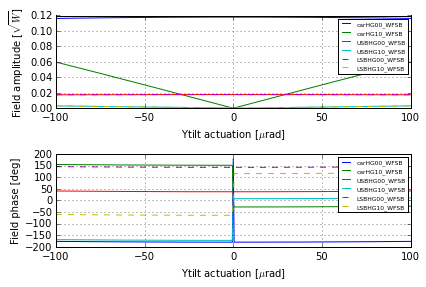

In [474]:
#Pads=["USBHG00_cavin","USBHG01_cavin","LSBHG00_cavin","LSBHG01_cavin"]
#Yads=["USBHG00_cavin","USBHG10_cavin","LSBHG00_cavin","LSBHG10_cavin"]
Yads=["carHG00_WFSA","carHG10_WFSA","USBHG00_WFSA","USBHG10_WFSA","LSBHG00_WFSA","LSBHG10_WFSA"]
Pads=["carHG00_WFSA","carHG01_WFSA","USBHG00_WFSA","USBHG01_WFSA","LSBHG00_WFSA","LSBHG01_WFSA"]

for DOF in DOFs:
    kat=basekat.deepcopy()
    kat.parseCommands("yaxis abs:deg")
    kat.maxtem = maxtem
    kat.parseCommands("""
        ad carHG00_WFSA 0 0 0 nPDHandWFSA
        ad USBHG00_WFSA 0 0 $fmod nPDHandWFSA
        ad LSBHG00_WFSA 0 0 $nfmod nPDHandWFSA
        ad carHG10_WFSA 1 0 0 nPDHandWFSA
        ad USBHG10_WFSA 1 0 $fmod nPDHandWFSA
        ad LSBHG10_WFSA 1 0 $nfmod nPDHandWFSA
        ad carHG01_WFSA 0 1 0 nPDHandWFSA
        ad USBHG01_WFSA 0 1 $fmod nPDHandWFSA
        ad LSBHG01_WFSA 0 1 $nfmod nPDHandWFSA
        """)
    kat.parseCommands(DOF_commands[DOF])

    out=kat.run(printerr=1)

    pl.figure()
    pl.subplot(211)
    if DOF[0]=='P':
        ads=Pads
    elif DOF[0]=='Y':
        ads=Yads
    for ad in ads:
        if ad[0]=='L':
            pl.plot(out.x*urad,abs(out[ad]),'--',label=ad)
        else:
            pl.plot(out.x*urad,abs(out[ad]),label=ad)
    pl.xlabel(DOF+" actuation [$\mu$rad]")
    pl.ylabel('Field amplitude [$\sqrt{W}$]')
    pl.legend()
    pl.legend(prop={'size':6})
    pl.grid()

    pl.subplot(212)
    for ad in ads:
        if ad[0]=='L':
            pl.plot(out.x*urad,pl.angle(out[ad])*180/pl.pi,'--',label=ad)
        else:
            pl.plot(out.x*urad,pl.angle(out[ad])*180/pl.pi,label=ad)
    
    pl.xlabel(DOF+" actuation [$\mu$rad]")
    pl.ylabel('Field phase [deg]')
    pl.legend()
    pl.legend(prop={'size':6})
    pl.grid()
    pl.tight_layout()
    pl.savefig('plots/cavinputbeam_allfields_WFSA_'+DOF+'.pdf')

#Pads=["USBHG00_cavin","USBHG01_cavin","LSBHG00_cavin","LSBHG01_cavin"]
#Yads=["USBHG00_cavin","USBHG10_cavin","LSBHG00_cavin","LSBHG10_cavin"]
Yads=["carHG00_WFSB","carHG10_WFSB","USBHG00_WFSB","USBHG10_WFSB","LSBHG00_WFSB","LSBHG10_WFSB"]
Pads=["carHG00_WFSB","carHG01_WFSB","USBHG00_WFSB","USBHG01_WFSB","LSBHG00_WFSB","LSBHG01_WFSB"]

for DOF in DOFs:
    kat=basekat.deepcopy()
    kat.parseCommands("yaxis abs:deg")
    kat.maxtem=5
    kat.parseCommands("""
        ad carHG00_WFSB 0 0 0 nWFSB
        ad USBHG00_WFSB 0 0 $fmod nWFSB
        ad LSBHG00_WFSB 0 0 $nfmod nWFSB
        ad carHG10_WFSB 1 0 0 nWFSB
        ad USBHG10_WFSB 1 0 $fmod nWFSB
        ad LSBHG10_WFSB 1 0 $nfmod nWFSB
        ad carHG01_WFSB 0 1 0 nWFSB
        ad USBHG01_WFSB 0 1 $fmod nWFSB
        ad LSBHG01_WFSB 0 1 $nfmod nWFSB
        """)
    kat.parseCommands(DOF_commands[DOF])

    out=kat.run(printerr=1)

    pl.figure()
    pl.subplot(211)
    if DOF[0]=='P':
        ads=Pads
    elif DOF[0]=='Y':
        ads=Yads
    for ad in ads:
        if ad[0]=='L':
            pl.plot(out.x*urad,abs(out[ad]),'--',label=ad)
        else:
            pl.plot(out.x*urad,abs(out[ad]),label=ad)
    pl.xlabel(DOF+" actuation [$\mu$rad]")
    pl.ylabel('Field amplitude [$\sqrt{W}$]')
    pl.legend()
    pl.legend(prop={'size':6})
    pl.grid()

    pl.subplot(212)
    for ad in ads:
        if ad[0]=='L':
            pl.plot(out.x*urad,pl.angle(out[ad])*180/pl.pi,'--',label=ad)
        else:
            pl.plot(out.x*urad,pl.angle(out[ad])*180/pl.pi,label=ad)
    
    pl.xlabel(DOF+" actuation [$\mu$rad]")
    pl.ylabel('Field phase [deg]')
    pl.legend()
    pl.legend(prop={'size':6})
    pl.grid()
    pl.tight_layout()
    pl.savefig('plots/cavinputbeam_allfields_WFSB_'+DOF+'.pdf')
